In [1]:
import keras
from keras.datasets import mnist
from keras.models import model_from_json
from keras.utils import np_utils
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense, Dropout

from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def generate_grads(x, label, model_name):
    model = model_from_json(open(model_name + 'model.json').read())
    model.load_weights(model_name + 'weights.h5')
    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])
    
    class_output = model.output[:, int(label)]
    
    grads = K.gradients(class_output, model.input)[0]
    gradient_function = K.function([model.input], [grads])

    grads_val = gradient_function([x.reshape(1, 784)])
    
    K.clear_session()
    
    return np.array(grads_val).reshape(784)

In [3]:
def generate_adv(x, label, model_name, eps):
    p = np.sign(generate_grads(x, label, model_name))
    
    adv = (x - eps*p).clip(min=0, max=1).reshape(784)
    
    return adv

In [4]:
def predict(x, model):
    pred = model.predict(x.reshape(1,784), batch_size=1)
    pred_class = np.argmax(pred)
    pred_per = max(pred[0])
    
    return pred_class, pred_per

In [5]:
num_list = [0, 1]

In [6]:
eps = 0.3

In [7]:
old_num_classes = 10
new_num_classes = 4

In [8]:
model_name = 'mnist_mlp_'
save_model_name = 'advs_all_random_class01_'

In [9]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784).astype('float32') / 255
X_test  = X_test.reshape(10000, 784).astype('float32') / 255

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [10]:
idxs_train_num = [i for i, n in enumerate(y_train) if n in num_list][:1000]
print(len(idxs_train_num))
X_train_num = []
y_train_num = []
for idx in idxs_train_num:
    X_train_num.append(X_train[idx])
    y_train_num.append(y_train[idx])
    
X_train_num = np.array(X_train_num)
y_train_num_catego = keras.utils.to_categorical(y_train_num, old_num_classes)

1000


In [11]:
idxs_test_num = [i for i, n in enumerate(y_test) if n in num_list][:200]
print(len(idxs_test_num))
X_test_num = []
y_test_num = []
for idx in idxs_test_num:
    X_test_num.append(X_test[idx])
    y_test_num.append(y_test[idx])
    
X_test_num = np.array(X_test_num)
y_test_num_catego = keras.utils.to_categorical(y_test_num, old_num_classes)

200


In [12]:
# モデルを読み込む
model = model_from_json(open(model_name + 'model.json').read())

# 学習結果を読み込む
model.load_weights(model_name + 'weights.h5')

print(model.summary())

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
____________________________________________________________

In [13]:
score = model.evaluate(X_test_num, y_test_num_catego, verbose=0)
print('0か1のみ')
print('Test loss :', score[0])
print('Test accuracy :', score[1])

0か1のみ
Test loss : 0.04024721733847855
Test accuracy : 0.99


In [14]:
def generate_adv_list(x_list, y_list, model_name, eps):
    adv_list = []
    
    for i, (x, y) in enumerate(zip(x_list, y_list)):
        if i % 100 == 0:
            print(i)
        adv = generate_adv(x, y, model_name, eps).reshape(784)
        adv_list.append(adv)
        
    return np.array(adv_list)

In [15]:
adv_test_num = generate_adv_list(X_test_num, y_test_num, model_name, eps)
adv_test_num.shape

0
100


(200, 784)

In [16]:
# モデルを読み込む
model = model_from_json(open(model_name + 'model.json').read())

# 学習結果を読み込む
model.load_weights(model_name + 'weights.h5')

print(model.summary())

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
score = model.evaluate(adv_test_num, y_test_num_catego, verbose=0)
print('0か1のadvs')
print('Test loss :', score[0])
print('Test accuracy :', score[1])

0か1のadvs
Test loss : 15.341705436706542
Test accuracy : 0.0


In [18]:
adv_train_num = generate_adv_list(X_train_num, y_train_num, model_name, eps)
adv_train_num.shape

0
100
200
300
400
500
600
700
800
900


(1000, 784)

In [19]:
X_adv_train = np.concatenate([X_train_num, adv_train_num])

In [20]:
y_adv_train = np.concatenate([y_train_num, np.array(list(map(lambda l: l + 2, y_train_num)))])
y_adv_train_catego = keras.utils.to_categorical(y_adv_train, new_num_classes)

X_adv_test = np.concatenate([X_test_num, adv_test_num])
y_adv_test = np.concatenate([y_test_num, np.array(list(map(lambda l: l + 2, y_test_num)))])
y_adv_test_catego = keras.utils.to_categorical(y_adv_test, new_num_classes)

(-5, 5)

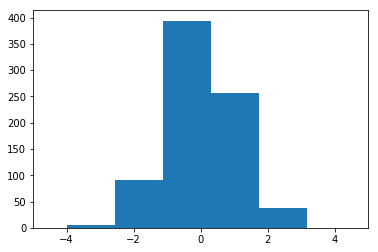

In [21]:
random_noise = np.random.normal(
    loc   = 0,      # 平均
    scale = 1,      # 標準偏差
    size  = (784),# 出力配列のサイズ
)
plt.hist(random_noise,bins=5)
plt.xlim(-5,5)

In [22]:
X_adv_train[0:500] = (X_adv_train[0:500] + eps*np.sign(random_noise)).clip(min=0, max=1)
X_adv_train.shape

(2000, 784)

(-5, 5)

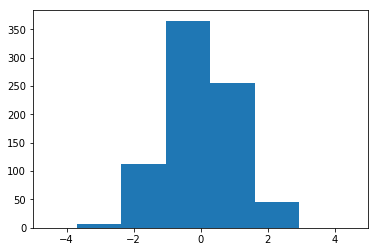

In [23]:
random_noise = np.random.normal(
    loc   = 0,      # 平均
    scale = 1,      # 標準偏差
    size  = (784),# 出力配列のサイズ
)
plt.hist(random_noise,bins=5)
plt.xlim(-5,5)

In [51]:
X_adv_test[100:200] = (X_adv_test[100:200] + eps*np.sign(random_noise)).clip(min=0, max=1)
X_adv_test.shape

(400, 784)

In [52]:
batch_size = 32
epochs = 20

In [53]:
model2 = Sequential()
model2.add(Dense(512, activation='relu', input_shape=(784,)))
model2.add(Dropout(0.2))
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(new_num_classes, activation='softmax'))

model2.summary()

model2.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])


history = model2.fit(X_adv_train, y_adv_train_catego,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_adv_test, y_adv_test_catego))

model_json_str = model2.to_json()
open(save_model_name + 'model.json', 'w').write(model_json_str)
model2.save_weights(save_model_name + 'weights.h5');
print('model saved.')


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 2052      
Total params: 666,628
Trainable params: 666,628
Non-trainable params: 0
_________________________________________________________________
Train on 2000 samples, validate on 400 samples
Epoch 1/20
2000/2000 [==============================] - 1s 503us/st

In [54]:
score = model2.evaluate(X_adv_test, y_adv_test_catego, verbose=0)
print('Test loss :', score[0])
print('Test accuracy :', score[1])

Test loss : 4.986967454438563
Test accuracy : 0.6475


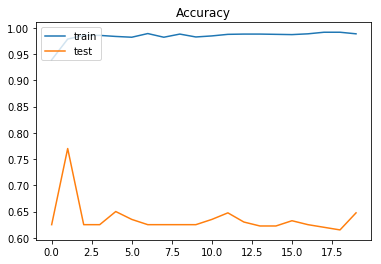

In [55]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

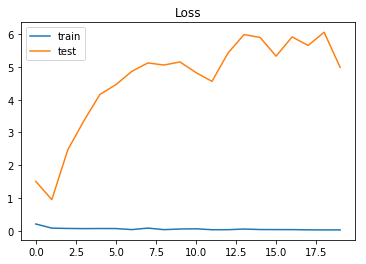

In [56]:

plt.cla()

# ロスの推移をプロット
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Text(0.5, 1.0, '1 -> 1 : 1.0')

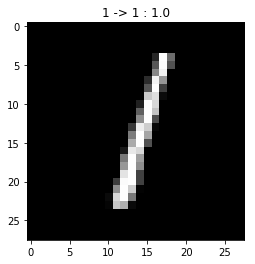

In [57]:
x = X_adv_test[0]
y = y_adv_test[0]

pred_class, pred_per = predict(x, model2)
plt.imshow(x.reshape(28,28), 'gray')
plt.title(f'{y} -> {pred_class} : {pred_per}')

Text(0.5, 1.0, '1 -> 3 : 1.0')

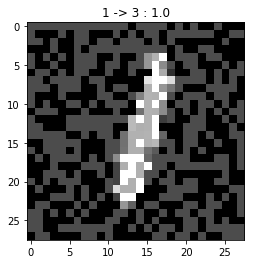

In [58]:
x = X_adv_test[100]
y = y_adv_test[100]

pred_class, pred_per = predict(x, model2)
plt.imshow(x.reshape(28,28), 'gray')
plt.title(f'{y} -> {pred_class} : {pred_per}')

Text(0.5, 1.0, '3 -> 3 : 1.0')

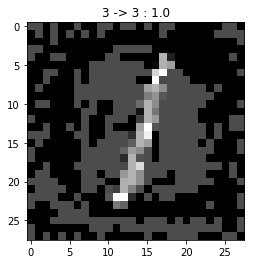

In [59]:
x = X_adv_test[200]
y = y_adv_test[200]

pred_class, pred_per = predict(x, model2)
plt.imshow(x.reshape(28,28), 'gray')
plt.title(f'{y} -> {pred_class} : {pred_per}')

In [60]:
score = model2.evaluate(X_adv_test[:100], y_adv_test_catego[:100], verbose=0)
print('Test loss :', score[0])
print('Test accuracy :', score[1])

Test loss : 5.806241188785061
Test accuracy : 0.58


In [61]:
score = model2.evaluate(X_adv_test[100:200], y_adv_test_catego[100:200], verbose=0)
print('Test loss :', score[0])
print('Test accuracy :', score[1])

Test loss : 14.141627807617187
Test accuracy : 0.01


In [62]:
score = model2.evaluate(X_adv_test[200:], y_adv_test_catego[200:], verbose=0)
print('Test loss :', score[0])
print('Test accuracy :', score[1])

Test loss : 1.1980533599853514e-07
Test accuracy : 1.0


In [63]:
model_name = 'advs_random_class01_'
# モデルを読み込む
model = model_from_json(open(model_name + 'model.json').read())

# 学習結果を読み込む
model.load_weights(model_name + 'weights.h5')

print(model.summary())

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 2052      
Total params: 666,628
Trainable params: 666,628
Non-trainable params: 0
_________________________________________________________________
None


In [64]:
score = model.evaluate(X_adv_test[:100], y_adv_test_catego[:100], verbose=0)
print('Test loss :', score[0])
print('Test accuracy :', score[1])

Test loss : 7.231002980172634
Test accuracy : 0.51


In [65]:
score = model.evaluate(X_adv_test[100:200], y_adv_test_catego[100:200], verbose=0)
print('Test loss :', score[0])
print('Test accuracy :', score[1])

Test loss : 16.069605407714842
Test accuracy : 0.0


In [66]:
score = model2.evaluate(X_adv_test[200:], y_adv_test_catego[200:], verbose=0)
print('Test loss :', score[0])
print('Test accuracy :', score[1])

Test loss : 1.1980533599853514e-07
Test accuracy : 1.0
